## Business Understanding

### Question 1: Which languages have been used the most each year?
### Question 2: Which languages have been the most unwanted?
### Question 3: Which languages are associated with the highest salaries?

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter

%matplotlib inline

## Data Understanding

In [17]:
# Gather data

dfs = [pd.read_csv(f"survey_results/survey_{i}.csv") for i in range(2018, 2021)]
dfs[0].head()


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
4,7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


In [ ]:
# assess and explore data

In [15]:
# compute total number of responses summing over all years
total_responses = 0
for df in dfs:
    total_responses += df.shape[0]
    
total_responses

252199

In [19]:
# number of columns in each year

for idx, df in enumerate(dfs):
    print(f"Year {idx + 2018}: {df.shape[1]} columns")

Year 2018: 129 columns
Year 2019: 85 columns
Year 2020: 61 columns


In [20]:
# focus question from the survey
schema_df = pd.read_csv('survey_results/schema_2020.csv')
list(schema_df[schema_df.Column == "LanguageWorkedWith"]["QuestionText"])[0]

'Which programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)'

In [14]:
# lets take a look at what the participants have responded with

dfs[2]["LanguageWorkedWith"].value_counts().reset_index().head()

,index,LanguageWorkedWith
0,HTML/CSS;JavaScript;PHP;SQL,1073
1,HTML/CSS;JavaScript,900
2,C#;HTML/CSS;JavaScript;SQL,856
3,C#;HTML/CSS;JavaScript;SQL;TypeScript,754
4,HTML/CSS;JavaScript;TypeScript,697


In [ ]:
"""
This doesn't look right. The languages are grouped together.
To get a count of each language worked with and which are loved and dreaded,
the following methods will clean the data and provide the count.

But, let's first assess other relevant data for the analysis
"""

In [25]:
# check the responses of salaries for all years

for idx, df in enumerate(dfs):
    try:
        print(df["Salary"].head())
    except:
        print(f"Salary column is not present in dataframe for the year {idx + 2018}")
    print()

0       NaN
1     51000
2       NaN
3       NaN
4    260000
Name: Salary, dtype: object

Salary column is not present in dataframe for the year 2019

Salary column is not present in dataframe for the year 2020



In [ ]:
"""
Looks like `Salary` column is renamed to `ConvertedComp` for the years 2019 and 2020.
Also we see there are rows with null values.
Let's clean up the data.
"""

## Preparing Data

In [29]:
def clean_data(df):
    """
    Cleans data for the salary and language worked with column in dataframe
    Params:
      :df: Dataframe object
    Returns: cleaned dataframe object
    """
    # rename to Salary if column not present
    if "Salary" not in df.columns:
        df.rename(columns={"ConvertedComp": "Salary"}, inplace=True)

    df = df.dropna(subset=["Salary", "LanguageWorkedWith"])
    return df

In [30]:
# now that we have a method to clean the data, we can loop over all the years to clean it

_dfs = []
for df in dfs:
    _dfs.append(clean_data(df))
dfs = _dfs

In [31]:
def count_worked_languages(df):
    """
    Returns a Counter of languages that developers are currently working with
    """
    data = df["LanguageWorkedWith"]

    languages = []
    for row in data:
        languages += [x.strip() for x in row.split(';')]
    return Counter(languages)

In [33]:
def count_loved_dreaded_languages(df):
    """
    Returns a tuple of Counters of loved and dreaded languages
    Loved: developers who are currently working with and express desire to work with next year
    Dreaded: developers who are currently working with and express no desire to work with next year
    """
    # drop rows where both columns have no values
    df = df.dropna(subset=["LanguageDesireNextYear"])
    data = df[["LanguageWorkedWith", "LanguageDesireNextYear"]]

    loved_languages = []
    dreaded_languages = []
    for row in data.iterrows():
        data_row = row[1]
        
        worked_with = []
        desired_next_year = []

        if not pd.isna(data_row["LanguageWorkedWith"]):
            worked_with = [lang.strip() for lang in data_row["LanguageWorkedWith"].split(';')]
        
        if not pd.isna(data_row["LanguageDesireNextYear"]):
            desired_next_year = [lang.strip() for lang in data_row["LanguageDesireNextYear"].split(';')]
            
        for lang in worked_with:
            if lang in desired_next_year:
                loved_languages.append(lang)
            else:
                dreaded_languages.append(lang)
        
    return Counter(loved_languages), Counter(dreaded_languages)

In [34]:
worked_with_counters = [count_worked_languages(df) for df in dfs]

In [35]:
loved_dreaded_counters = [count_loved_dreaded_languages(df) for df in dfs]

In [43]:
"""
Now we have count of languages worked with, and which are loved and dreaded
Let's see how it looks like for year 2020
"""

pd.DataFrame(pd.Series(worked_with_counters[2])).reset_index().rename(
    columns={"index": "Language", 0: "Count"}).head()

,Language,Count
0,Python,13931
1,SQL,19340
2,HTML/CSS,20907
3,Java,12380
4,JavaScript,23619


In [ ]:
"""
using this, we can calculate the percentage of users loving and dreading it and 
finally save it in the respective counters
"""

In [49]:
loved_counters = []
dreaded_counters = []

for idx, worked_with_counter in enumerate(worked_with_counters):
    loved_counter = Counter()
    dreaded_counter = Counter()
    for lang, cnt in worked_with_counter.items():
        if cnt != 0:
            loved_counter[lang] = loved_dreaded_counters[idx][0][lang] / cnt * 100
            dreaded_counter[lang] = loved_dreaded_counters[idx][1][lang] / cnt * 100
    loved_counters.append(loved_counter)
    dreaded_counters.append(dreaded_counter)
    
_worked_with_counters = []

for idx, counter in enumerate(worked_with_counters):
    _counter = Counter()
    for lang, cnt in counter.items():
        _counter[lang] = (cnt / dfs[idx].shape[0]) * 100
    _worked_with_counters.append(_counter)
    
worked_with_counters = _worked_with_counters

In [50]:
"""
checking the results for year 2020
"""

pd.DataFrame(pd.Series(worked_with_counters[2])).reset_index().rename(
    columns={"index": "Language", 0: "% of Users"}).head()

,Language,% of Users
0,Python,41.650970
1,SQL,57.822824
2,HTML/CSS,62.507848
3,Java,37.013783
4,JavaScript,70.616199


In [ ]:
"""
the following methods will be used to plot the bar charts
"""

In [58]:
def plot_bar_chart(data, xticks, xlabel, ylabel, title):
    """
    Plots bar chart labelling the axes, adding the title and providing a list of labels `xticks`
    for the x axis
    Params:
      :data: list of numbers
      :xticks: list of strings to label the x axis
      :xlabel: x axis label
      :ylabel: y axis label
      :title: title of the bar chart
    Returns: None
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.bar(range(len(data)), data, align="center")
    plt.xticks(range(len(xticks)), xticks)
    plt.show()

In [60]:
def plot_counters_chart(counters, num_most_common, title):
    """
    Plots bar chart showing % of users for each language
    Params:
      :counters: list of `collections.Counter` object mapping each language to percentage of users
      :num_most_common: grabs number of most common items from each counter
      :title: title of the bar chart
    Returns: None
    """
    for idx, counter in enumerate(counters):
        year = idx + 2018
        
        # pick the `num_most_common` most common items
        data = dict(counter.most_common(num_most_common))
        
        # plot chart
        plot_bar_chart(data.values(), data.keys(), "Language", "% of Users", f'{title} in year {year}')

## Evaluating Results

### Question 1: Which languages have been used the most each year?
### Question 2: Which languages have been the most unwanted?

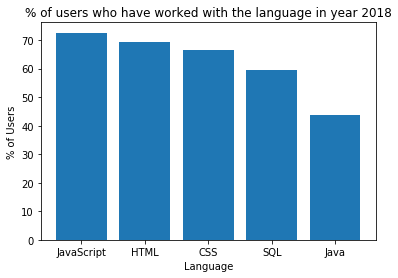

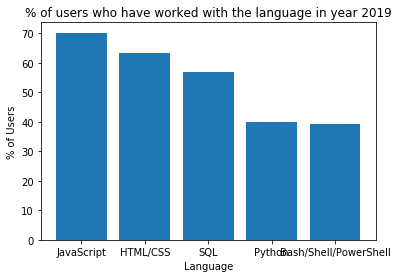

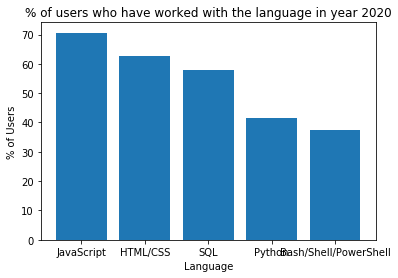

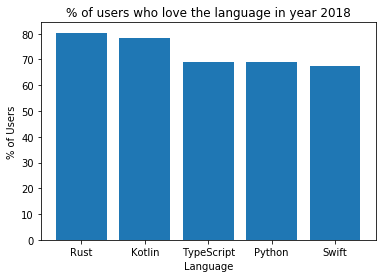

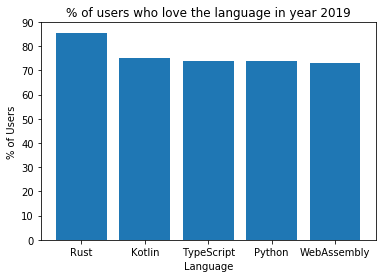

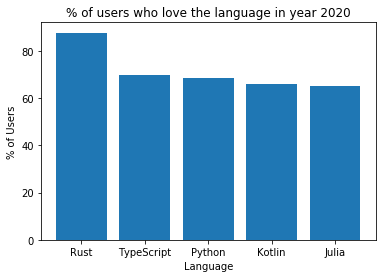

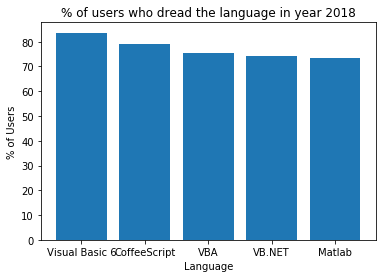

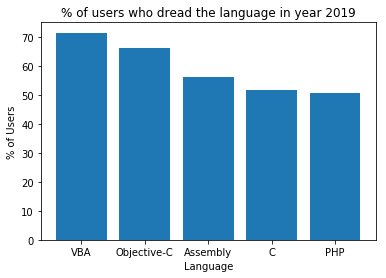

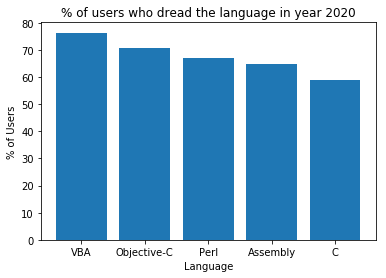

In [62]:
"""
Plot % of users v/s Language for all years for all counters
"""

plot_counters_chart(worked_with_counters, 5, "% of users who have worked with the language")
plot_counters_chart(loved_counters, 5, "% of users who love the language")
plot_counters_chart(dreaded_counters, 5, "% of users who dread the language")

You can see that JavaScript has been consistently at the top over the years when it comes to developers working with it. But, Rust has been the most loved language when you see the developers who also want to continue working with it. Python, the second most loved language in 2019, surpassed by Typescript in 2020, placed third.

Looking at the most dreaded languages — the ones which developers are working with, but haven’t expressed any interest to work with it in the next year. You can see from the charts that VBA have been the most dreaded language with Objective-C, Perl and C right behind it.

In [59]:
"""
Next, we find out the salary associated with each language
"""

In [54]:
def compute_language_median(df, language):
    """
    Computes the median salary for the language
    Params:
      :df: Dataframe for a particular year
      :language: string
    """

    # drop all rows where LanguageWorkedWith or Salary is null
    df = df.dropna(subset=["LanguageWorkedWith", "Salary"])
    
    # clean values which are not float
    def is_float(x):
        """Returns true if value can be parsed to float else False"""
        try:
            float(x)
        except ValueError:
            return False
        return True

    df = df[df["Salary"].apply(is_float)]
    
    # filter to rows where LanguageWorkedWith contains the language
    df = df[df["LanguageWorkedWith"].str.contains(language)]
    df = df[["LanguageWorkedWith", "Salary"]]

    # if dataframe is empty return zero
    if df.empty:
        return 0

    # return the median converted to float
    return df["Salary"].astype('float').median()

In [52]:
# The below variable contains the list of all languages picked from the year 2020
all_languages = [
    "Assembly",
    'Bash/Shell/PowerShell',
    'C',
    'C#',
    'C++',
    'Dart',
    'Go',
    'Haskell',
    'HTML/CSS',
    'Java',
    'JavaScript',
    'Julia',
    'Kotlin',
    'Objective-C',
    'Perl',
    'PHP',
    'Python',
    'R',
    'Ruby',
    'Rust',
    'Scala',
    'SQL',
    'Swift',
    'TypeScript',
    'VBA'
]

In [55]:
# compute top salaries for all years for all languages

top_salaries = {}

for year in range(2018, 2021):
    top_salaries[year] = {}
    for lang in all_languages:
        avg_salary = compute_language_median(
            dfs[year-2018],
            re.escape(lang)
        )
        top_salaries[year][lang] = avg_salary

In [57]:
# let's see how it looks like

pd.DataFrame(pd.Series(top_salaries[2020])).reset_index().rename(
    columns={"index": "Language", 0: "Salary ($)"}).head()

,Language,Salary ($)
0,Assembly,52942.0
1,Bash/Shell/PowerShell,65052.0
2,C,53530.0
3,C#,56723.0
4,C++,53196.0


## Evaluating Results

### Question 3: Which languages are associated with the highest salaries?

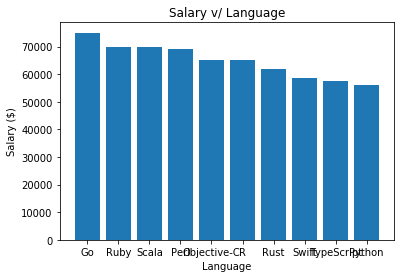

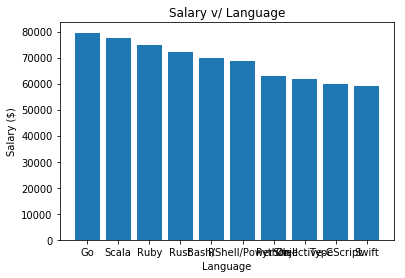

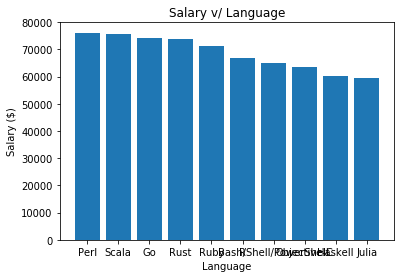

In [63]:
# plot Salary v/s Language chart for all years
for year, lang_dict in top_salaries.items():
    # showing only 10 most common items for better visibility
    data = Counter(dict(Counter(lang_dict).most_common(10)))
    
    # plot chart
    plot_bar_chart(data.values(), data.keys(), "Language", "Salary ($)", "Salary v/ Language")

You can see that Perl, Scala and Go tend to have the highest salaries around $75,000. It is interesting to note that Perl is also one of the most dreaded languages. One possible explanation for this high salary could be to compensate for all the dread to use the language.